# Identify Fraud from Eron Email

# Workflow

- Get the data from the pickle file
- Explore the data
- Cleanup the data (process the 'NaN' and remove the TOTAL entry)
- Check for ouliers
- Remove the outliers
- Add meta-features
- Select the features (SelectKBest, SelectPercentile or lasso of sklearn)
- Run a classifer
- Check the precision and recall 
- Tune the classifier parameter and iterate to step 6 with another classifer
- Iterate to step 5 to try with another set of features

In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

%matplotlib inline

In [2]:
features_list = ['poi','salary', 'bonus']

# Get the data from the pickle file

This step is quite easy. We have just to read the dataset from the pkl file. We will obtain a dictionary of the data. 

In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    my_dataset = data_dict

# Data Exploration

In [4]:
print("There is %i entries in the dataset"%(len(my_dataset.keys())))

There is 146 entries in the dataset


In [5]:
print("for each entry, there is %i features"%(len(my_dataset['METTS MARK'].keys())))

for each entry, there is 21 features


In [6]:
listOfFeatures = my_dataset['METTS MARK'].keys()

In [7]:
NaN_Cpt = [0]*len(listOfFeatures)
nonNaN_Cpt = [0]*len(listOfFeatures)
totalCpt = [0]*len(listOfFeatures)

for p in my_dataset:
    for i in range(len(listOfFeatures)):
        if my_dataset[p][listOfFeatures[i]] == 'NaN':
            NaN_Cpt[i] += 1
        else:
            nonNaN_Cpt[i] += 1
        totalCpt[i] += 1

In [8]:
df = pd.DataFrame([NaN_Cpt, nonNaN_Cpt, totalCpt],index=['Amount of NaN', 'Amount of non NaN', 'Total'],columns=listOfFeatures)

In [9]:
df.sum(axis=1)

Amount of NaN        1358
Amount of non NaN    1708
Total                3066
dtype: int64

In [10]:
1358/3066.0

0.4429223744292237

44% of all the value are 'NaN'

Let see per attributes.

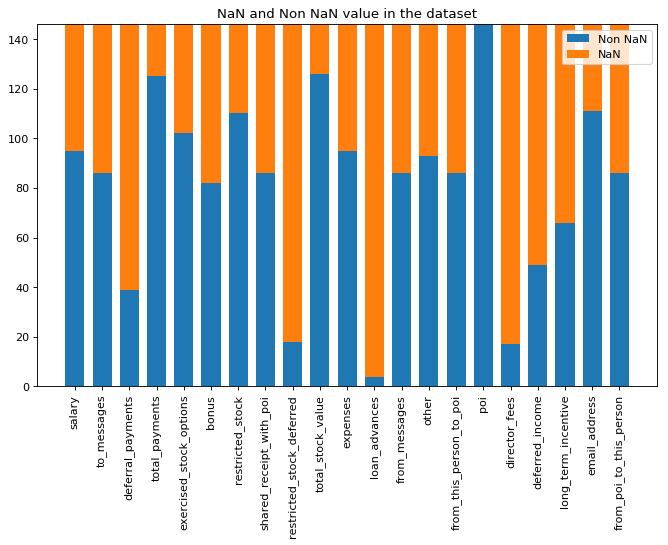

In [11]:
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ind = range(len(listOfFeatures))
width = 0.7

p1 = plt.bar(ind, nonNaN_Cpt, width)
p2 = plt.bar(ind, NaN_Cpt, width, bottom=nonNaN_Cpt)
plt.title('NaN and Non NaN value in the dataset')
plt.xticks(range(len(listOfFeatures)), listOfFeatures, rotation=90)
plt.legend((p1[0], p2[0]), ('Non NaN', 'NaN'))
plt.savefig('NaN_Value.png', bbox_inches='tight')
plt.show()


There is a lot of unknown values. We can notice that the attributes 'loan_advance', 'restricted_stock_value' and 'director_fees contains very few information.

There is no NaN Value for the attribute POI.  

We want to identify the POIs. We saw that there is no NaN value for them. How many do we have?

In [12]:
POI = 0
non_POI = 0
strange_POIValue = 0

for p in my_dataset:
    if my_dataset[p]['poi'] == 0:
        non_POI += 1
    elif my_dataset[p]['poi'] == 1:
        POI += 1
    else:
        strangePOIValue += 1

print("POI: %i\nNon POI: %i\nNon valid value: %i"%(POI, non_POI, strange_POIValue))

POI: 18
Non POI: 128
Non valid value: 0


There is 18 Person of interest in the dataset and no non valid value was found.

# Cleanup the data

In order to select the features later, we have to extract all fields of the dataset.

In [13]:
all_features_list = my_dataset['BECK SALLY W'].keys()

The 'email_address' field should be remove. It is unique for each people. This field add no information to identify the POIs. And should be removed.

We have also to remove the 'TOTAL' entry. Which will generate outliers and does not add any discrimination of the POIs.

In [14]:
del my_dataset['TOTAL']
all_features_list.remove('email_address')

Now we can call the featureFormat function which will replace the 'NaN' value by 0 and extract data in a table.

We have also to place the 'poi' field at the first entry of the list

In [15]:
all_features_list.remove('poi')
all_features_list.insert(0, 'poi')
data = featureFormat(my_dataset, all_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Check for Outliers

Let plot each features to have a over all view of how the data look like.

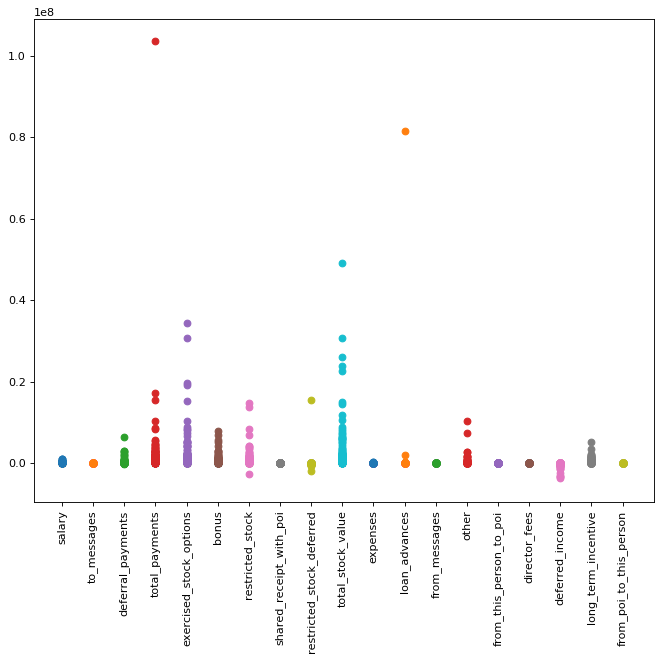

In [16]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
x_list = []
y_list = []

for f in range(len(all_features_list) - 1):
    y = np.array(features)[..., f]
    x = [f]*len(features)
    x_list.append(x)
    y_list.append(y)
    
for i in range(len(y_list)):
    plt.scatter(x_list[i],y_list[i])
plt.xticks(range(len(all_features_list) - 1), all_features_list[1:], rotation=90)
plt.show()

We see three points which are really separate from the rest but the scale of the graph can hide some details. The three points are for the fields total_payement, total_stock_value and loan_advance. A better tool is needed to have a closer look on each fields separatly.

## Processing the z-score of the samples

With the z-score we will be able to see the samples which are really far from the normality. The z-score will also do a sort of normalization which will help to see all fields on one graph.

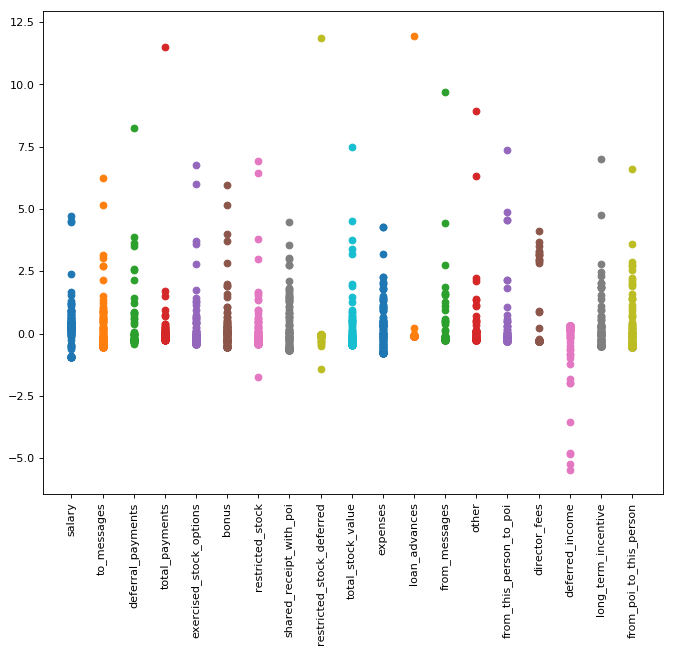

In [17]:
from scipy import stats

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
x_list = []
y_list = []

for f in range(len(all_features_list) - 1):
    y = stats.zscore(np.array(features)[..., f])
    x = [f]*len(features)
    x_list.append(x)
    y_list.append(y)
    
zScore_list = y_list
    
for i in range(len(y_list)):
    plt.scatter(x_list[i],y_list[i])
plt.xticks(range(len(all_features_list) - 1), all_features_list[1:], rotation=90)
plt.show()

We can notice interessing things. First the values are really widly spread. This is probably due to the missing data are replaced by zero. Secondly we can confirm that the total_payment and the loan advance maximum seem strange but the total_stock_value seems to be like other fields. 

## Analysis of the outliers

We will check all value with a z-Score greater than 4 and smaller than -2.

In [18]:
max_zScore = 4
min_zScore = -2
nbOfOutliers = 0
for f in range(len(all_features_list) - 1):
    outliers = []
    for i in range(len(zScore_list[f])):
        if (zScore_list[f][i] > max_zScore) or (zScore_list[f][i] < min_zScore):
            print("%s to be check.\tValue: %i"%(all_features_list[f+1], features[i][f]))
            nbOfOutliers += 1
print("-------------------\n%i outliers found"%(nbOfOutliers))

salary to be check.	Value: 1060932
salary to be check.	Value: 1072321
salary to be check.	Value: 1111258
to_messages to be check.	Value: 12754
to_messages to be check.	Value: 15149
deferral_payments to be check.	Value: 6426990
total_payments to be check.	Value: 103559793
exercised_stock_options to be check.	Value: 30766064
exercised_stock_options to be check.	Value: 34348384
bonus to be check.	Value: 8000000
bonus to be check.	Value: 7000000
bonus to be check.	Value: 5600000
restricted_stock to be check.	Value: 14761694
restricted_stock to be check.	Value: 13847074
shared_receipt_with_poi to be check.	Value: 5521
restricted_stock_deferred to be check.	Value: 15456290
total_stock_value to be check.	Value: 30766064
total_stock_value to be check.	Value: 49110078
expenses to be check.	Value: 228763
expenses to be check.	Value: 228656
loan_advances to be check.	Value: 81525000
from_messages to be check.	Value: 14368
from_messages to be check.	Value: 6759
other to be check.	Value: 7427621
ot

There is no irealistic value. The values match with the PDF from findLaw. We can ask us if two people really sent more than 12000 emails. Let check who are those people.

In [19]:
for i in my_dataset:
    if my_dataset[i]['to_messages'] > 12000 and my_dataset[i]['to_messages'] != 'NaN':
        print("%s: %s mails sent"%(i, my_dataset[i]['to_messages']))

SHAPIRO RICHARD S: 15149 mails sent
KEAN STEVEN J: 12754 mails sent


Those values are high but plausible. We have to keep in mind if we choose the amount of mail as a feature. 

# Add meta-data

In order to improve the results of the classifier, it is possible to add some meta-features. Thoses features are calculated from other value in the dataset.

In our case three values can be nice to have:
- The total benefit (total_payments + total_stock_value)
- The fraction of mails to/from POI

## Add the total benefit meta-feature

We add a field to calculate the total benefit per people. We just add the total_payments and the total_stock_value together.

In [20]:
for p in my_dataset:
    if my_dataset[p]['total_payments'] != 'NaN':
        total_payments = my_dataset[p]['total_payments']
    else:
        total_payments = 0
        
    if my_dataset[p]['total_stock_value'] != 'NaN':
        total_stock_value = my_dataset[p]['total_stock_value']
    else:
        total_stock_value = 0
    
    my_dataset[p]['total_benefit'] = total_payments + total_stock_value
    


A new field "total benefit" is added in the dataset

## Add the fraction of mail to/from POI

The number of email is relative. To see the amount of mail exchange to and from a POI, we can add two fields which represent the fraction of the the mail received of sent from or to a POI by the total number of mail received or sent.

In [21]:
def check_value(v):
    if v != 'NaN':
        return v
    else:
        return 0

for p in my_dataset:
    to_message = check_value(my_dataset[p]['to_messages'])
    from_message = check_value(my_dataset[p]['from_messages'])
    from_poi_to_this_person = check_value(my_dataset[p]['from_poi_to_this_person'])
    from_this_person_to_poi = check_value(my_dataset[p]['from_this_person_to_poi'])
    
    if to_message == 0:
        my_dataset[p]['fraction_from_poi'] = 0
    else:
        my_dataset[p]['fraction_from_poi'] = from_poi_to_this_person / float(to_message)
    if from_message == 0:
        my_dataset[p]['fraction_to_poi'] = 0
    else:    
        my_dataset[p]['fraction_to_poi'] = from_this_person_to_poi / float(from_message)
    

Two new fields "fraction_from_poi" and "fraction_to_poi" are added in the dataset

In [22]:
all_features_list

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person']

# Select the features

In [23]:
all_features_list = my_dataset['BECK SALLY W'].keys()
all_features_list.remove('email_address')
all_features_list.remove('poi')
all_features_list.insert(0, 'poi')
data = featureFormat(my_dataset, all_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


In [24]:
selector = SelectKBest(f_classif, k=6)
features_selected =selector.fit_transform(features, labels)

In [25]:
cpt = 1
print("| Feature | Score |\n---|---")
for i in selector.get_support():
    if i == True:
        print("| %s \t| %f |"%(all_features_list[cpt], selector.scores_[cpt-1]))
    cpt += 1

| Feature | Score |
---|---
| bonus 	| 21.060002 |
| total_stock_value 	| 24.467654 |
| salary 	| 18.575703 |
| fraction_to_poi 	| 16.641707 |
| exercised_stock_options 	| 25.097542 |
| total_benefit 	| 17.187006 |


In [26]:
selector.scores_

array([  1.69882435,   0.21705893,   6.23420114,  11.59554766,
        10.07245453,   3.21076192,   0.06498431,   8.74648553,
         7.2427304 ,   0.1641645 ,   4.20497086,   2.10765594,
        21.06000171,  24.46765405,   5.34494152,   2.42650813,
         9.34670079,  18.57570327,   8.86672154,  16.64170707,
        25.09754153,  17.18700608])

# Run classifiers

In [27]:
def testClassifier(clf, features_train, labels_train, features_test, labels_test):
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    accuracy = accuracy_score(labels_test, pred)
    
    return accuracy

In [28]:
scaler = MinMaxScaler()
features_rescaled = scaler.fit_transform(features_selected)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
gaussianBayes = GaussianNB()
mySVC = SVC(C=1.0, kernel='rbf', degree=3)
testClassifier(mySVC, features_train, labels_train, features_test, labels_test)

0.89583333333333337

In [29]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
mySVC = SVC(gamma='scale')
clf = GridSearchCV(mySVC, parameters, cv=5)
clf.fit(features_train, labels_train)
#testClassifier(mySVC, features_train, labels_train, features_test, labels_test)

TypeError: a float is required